# Анализ программы лояльности

<a id=up></a>
## Содержание
- Подключение библиотек
- **1.Предобработка данных**
    - [1.1.Проверка общей информации](#1_1)
    - [1.2.Форматирование названий столбцов](#1_2)
    - [1.3.Изменение типов данных](#1_3)
    - [1.4.Обработка дубликатов](#1_4)
    - [1.5.Обработка пропусков](#1_5)
- **2.Исследовательский анализ данных**    
    - [2.1.Поиск аномалий](#2_1)
- **3.Анализ программы лояльности**
    - [3.1.Частота покупок на одного клиента: в неделю, в месяц, в день](#3_1)
    - [3.2.Среднее количество товаров в корзине](#3_2)
    - [3.3.Средняя сумма корзины](#3_3)
    - [3.4.Коэффицинт удержания клиентов первого месяца RetantionRate](#3_4)
    - [3.5.Ценность клиентов первого месяца LTV](#3_5)
- **4.Проверка статистических гипотез**
    - [4.1.Количество товаров в корзине](#4_1)
    - [4.2.Сумма корзины](#4_2)
- **5.Машинное обучение**
    - [5.1.Классификация](#5_1)
    - [5.2.Кластеризация](#5_2)
- [**6.Вывод**](#6_)

### Подключение библиотек

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import numpy as np
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## 1.Предобработка данных

<a id=1_1></a>
### 1.1.Проверка общей информации
[вверх](#up)

Выгрузим данные, и выведем общую информацию по обеим таблицам.

In [2]:
retail_dataset = pd.read_csv('datasets/retail_dataset.csv')
product_codes  = pd.read_csv('datasets/product_codes.csv')
print(retail_dataset.info())
print(product_codes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB
None


Примерно треть данных об id пользователей отстутствует. Выведем случайные пять строк каждой таблицы:

In [3]:
display(retail_dataset.sample(5))
display(product_codes.sample(5))

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
24424,537623,22613,2,2016-12-07 14:31:00,21537.0,Shop 0,0.0
41526,543467,84792,0,2017-02-08 14:35:00,NaN,Shop 0,0.0
6653,537335,22699,1,2016-12-06 12:15:00,20727.0,Shop 0,0.0
45600,543358,21672,6,2017-02-07 14:04:00,NaN,Shop 0,0.0
48126,540816,84378,11,2017-01-11 12:55:00,21197.0,Shop 0,0.0


,productID,price_per_one
2675,21240,1.66
6772,21931,4.13
3779,84707A,9.95
7871,22964,4.13
4714,35610C,2.51


Проверим содержимое столбцов:

In [4]:
print('Таблица', '\033[7m' + 'retail_dataset:' + '\033[0m')
print(retail_dataset.purchaseid.nunique())
print(retail_dataset.item_ID.nunique())
print(retail_dataset.Quantity.describe())
print(retail_dataset.purchasedate.min())
print(retail_dataset.purchasedate.max())
print(retail_dataset.CustomerID.nunique())
print(retail_dataset.ShopID.nunique())
print(retail_dataset.loyalty_program.value_counts())
print('Таблица', '\033[7m' + 'product_codes:' + '\033[0m')
print(product_codes.productID.nunique())
print(product_codes.price_per_one.describe())

Таблица retail_dataset:
4894
3159
count    105335.000000
mean          7.821218
std         327.946695
min      -74216.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: Quantity, dtype: float64
2016-12-01 08:26:00
2017-02-28 17:04:00
1749
31
0.0    81493
1.0    23842
Name: loyalty_program, dtype: int64
Таблица product_codes:
3159
count     9969.000000
mean        19.503697
std        330.880754
min          0.000000
25%          1.250000
50%          2.550000
75%          5.510000
max      16888.020000
Name: price_per_one, dtype: float64


**Мы располагаем следующими данными. Имеем:**
- `почти 5 тысяч чеков;`
- чуть более 3 тысяч уникальных товаров;
- `в среднем, почти 8 товаров в чеке. Есть выбросы и отрицательные значения;`
- данные за три месяца: с 01 декабря 2016 по 28 февраля 2017;
- `1749 уникальных клиентов;`
- 31 магазин;
- `примерно пятая часть чеков пришлась на "лояльных" клиентов;`
- три четверти товараов стоят не дороже 6 рублей. Есть выбросы.

<a id=1_2></a>
### 1.2.Форматирование названий столбцов
[вверх](#up)

Приведём названия столбцов в надлежащий вид:

In [5]:
retail_dataset = retail_dataset.rename(columns={
    'purchaseid'     : 'purchase_id',
    'item_ID'        : 'product_id',
    'Quantity'       : 'count_products',
    'purchasedate'   : 'purchase_dt',
    'CustomerID'     : 'customer_id',
    'ShopID'         : 'shop_id',
    'loyalty_program': 'loyal'
})
product_codes = product_codes.rename(columns={
    'productID'      : 'product_id',    
    'price_per_one'  : 'cost_product'
})
display(retail_dataset.head(2))
display(product_codes.head(2))

,purchase_id,product_id,count_products,purchase_dt,customer_id,shop_id,loyal
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0


,product_id,cost_product
0,85123A,2.55
1,71053,3.39


<a id=1_3></a>
### 1.3.Изменение типов данных
[вверх](#up)

Распишем текущее состояние.

Таблица **`retail_dataset`**:
- столбец `purchase_id` содержит значения с буквами в составе, например: 'C539944';
- столбец `product_id` содержит значения с буквами в составе, например: '82494L';
- столбец `count_products` имеет верный формат: 'int64';
- столбец `purchase_dt` **необходимо перевести** в формат: 'datetime64';
- столбец `customer_id` содержит пропуски, 'float64' - верный формат;
- столбец `shop_id` имеет верный формат, но **можно поменять** значения на числа (формат: 'int64');
- столбец `loyal` **можно перевести** в формат: 'int32'.

Таблица **`product_codes`**:
- столбец `product_id` имеет верный формат: 'object';
- столбец `cost_product` имеет верный формат: 'float64'.

Изменяем тип данных:

In [6]:
retail_dataset.purchase_dt = retail_dataset.purchase_dt.astype('datetime64')
retail_dataset.shop_id = retail_dataset.shop_id.map(lambda x: x[5:]).astype('int')
retail_dataset.loyal = retail_dataset.loyal.astype('int')
retail_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   purchase_id     105335 non-null  object        
 1   product_id      105335 non-null  object        
 2   count_products  105335 non-null  int64         
 3   purchase_dt     105335 non-null  datetime64[ns]
 4   customer_id     69125 non-null   float64       
 5   shop_id         105335 non-null  int32         
 6   loyal           105335 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(2)
memory usage: 4.8+ MB


<a id=1_4></a>
### 1.4.Обработка дубликатов
[вверх](#up)

Сохраним в переменной изначальный размер датиафрейма. Будем определять по нему процентное соотношение удалённых данных.  
Проверим таблицы на наличие полных дубликатов:

In [7]:
retail_dataset_len_original = retail_dataset.shape[0]
print(retail_dataset_len_original)
product_codes_len_original = product_codes.shape[0]
print(product_codes_len_original)
print(retail_dataset.duplicated().sum())
print(product_codes.duplicated().sum())

105335
9969
1033
0


Выведим примеры дубликатов:

In [8]:
retail_dataset[retail_dataset.duplicated() == True].head()

,purchase_id,product_id,count_products,purchase_dt,customer_id,shop_id,loyal
5345,537265,21499,24,2016-12-06 11:26:00,21598.0,0,0
5863,540803,21485,0,2017-01-11 12:30:00,20348.0,0,0
6893,540524,21326,11,2017-01-09 12:53:00,22414.0,0,1
7821,537192,22585,0,2016-12-05 13:42:00,22081.0,0,1
10806,537772,22080,4,2016-12-08 12:35:00,23722.0,0,1


Два одинаковых чека, на одного и того же покупателя можно пробить только по ошибке. Иначе, было бы различие хотя бы по id чеков. В каких магазинах они были:

In [9]:
retail_dataset[retail_dataset.duplicated() == True].shop_id.value_counts()

0     1023
25       4
6        2
4        2
18       1
2        1
Name: shop_id, dtype: int64

Не во всех. В какой промежуток времени они появлялись:

In [10]:
retail_dataset[retail_dataset.duplicated() == True].purchase_dt.describe()

count                    1033
unique                    370
top       2016-12-08 12:46:00
freq                       25
first     2016-12-01 11:45:00
last      2017-02-28 15:19:00
Name: purchase_dt, dtype: object

Диапазон дат соответствует диапазону всего датасета, но есть небольшое отличие по времени продажи. Проврерим, в какие часы появилось наибольшое количество дубликатов:

In [11]:
duplicated_hour = retail_dataset[retail_dataset.duplicated() == True].purchase_dt
duplicated_hour = duplicated_hour.map(lambda x: x.strftime('%H')).sort_values().astype('int')
duplicated_hour

53510     9
39698     9
77715     9
66691     9
88014    10
         ..
89447    19
72827    19
29624    19
51817    19
43050    19
Name: purchase_dt, Length: 1033, dtype: int32

Отобразим на гистограмме. Перед этим, создадим функцию:

In [12]:
def captions_to_graphics(title, xlabel, ylabel):
    '''
    - принимает на вход: заголовок, подпись оси X, подпись оси Y
    - передаёт полученные значения графику, устанавливая определённые свойства:
    - выделяет тексты жирным, задаёт необходимую высоту
    '''
    plt.title(title,
              fontsize=16,
              fontweight='bold')
    plt.xlabel(xlabel,
               fontsize=13,
               fontweight='bold')
    plt.ylabel(ylabel,
               fontsize=13,
               fontweight='bold')

Строим гистограмму:

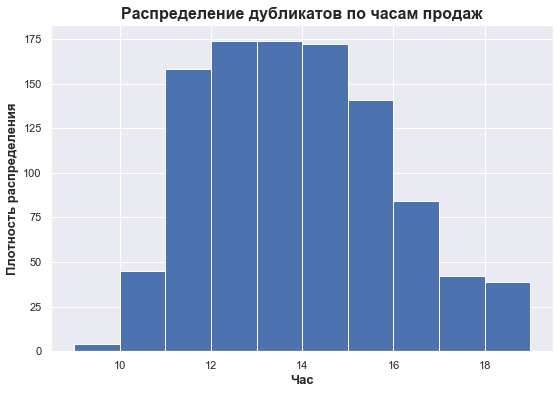

In [13]:
sns.set(style = 'darkgrid')
plt.figure(figsize=(9, 6))
plt.hist(duplicated_hour)
captions_to_graphics(
    'Распределение дубликатов по часам продаж',
    'Час',
    'Плотность распределения')
plt.show()

Есть вероятность, что рост количества дубликатов связан с ростом количества продаж (чеков). Иными словами, кассиры делают больше ошибок в часы пик. Избавимся от дубликатов: 

In [14]:
retail_dataset_step1 = retail_dataset.drop_duplicates().copy()
retail_dataset_len_step1 = retail_dataset_step1.shape[0]
print('Удалили данных на данном этапе: {:.1%}'.format(1 - retail_dataset_len_step1/retail_dataset_len_original))

Удалили данных на данном этапе: 1.0%


Дубликаты в отдельных столбцах таблицы `retail_dataset` естественны. Так же, естественны дубликаты по стоимости товара. Проверим на наличие дубликатов столбец `product_id` таблицы `product_codes`: 

In [15]:
product_codes.product_id.duplicated().sum()

6810

Очень большое количество дубликатов!  
Есть несколько причин, по которым в базу данных могли заносить разную стоимость товаров:
- заносили фактическую стоимость проданного товара исходя из размера скидки, и действующих акций;
- стоимость товара рассчитывалась исходя из стоимости закупки (партии отличающиеся по дате закупке, контрагенту, курсу валюты и прочее);
- стоимость товара менялась исходя из ценовой политики торговой сети.

>Рекомендация для дата-инженеров: **необходимо добавить в таблицу product_codes столбец с датой.**

Мы не располагаем данными о дате занесения новой цены. Но, мы можем оттолкнуться от порядкового номера индеска строки, и посмотреть динамику. Найдём товары с наибольшим количеством дубликатов по цене:

In [16]:
product_codes.product_id.value_counts().head(10).index

Index(['DOT', 'M', 'S', 'POST', 'D', '79321', '84406B', '47566', '22834',
       'AMAZONFEE'],
      dtype='object')

In [17]:
DOT_costs_plot = product_codes.query('product_id == "DOT"')
DOT_costs_plot

,product_id,cost_product
1203,DOT,569.77
1866,DOT,607.49
2430,DOT,254.43
2458,DOT,121.06
2507,DOT,498.47
...,...,...
9882,DOT,79.67
9883,DOT,137.96
9893,DOT,147.49
9927,DOT,265.19


Посмотрим распределение цены во времени на графике:

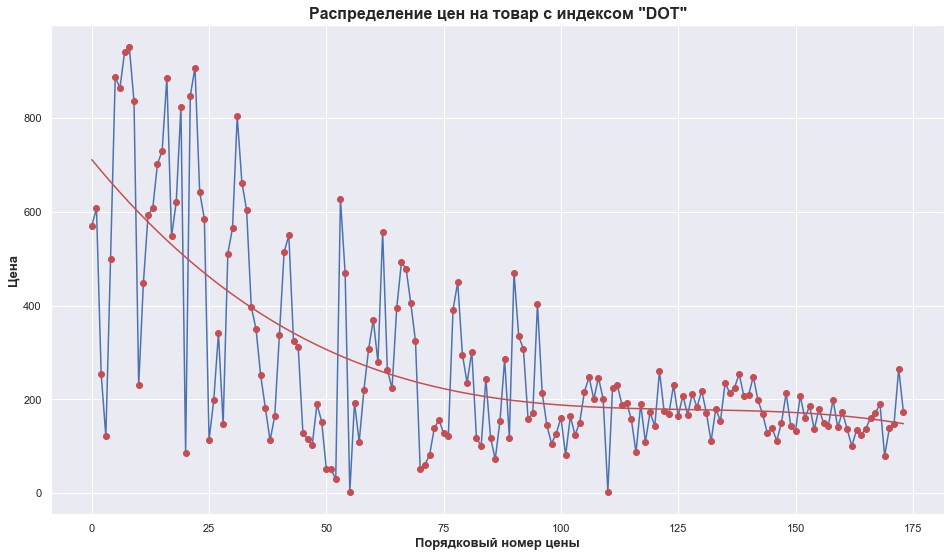

In [18]:
DOT_costs_plot = DOT_costs_plot.reset_index(drop=True)
x = DOT_costs_plot.index
y = DOT_costs_plot.cost_product
plt.figure(figsize=(16, 9))
pylab.plot(x,y)
pylab.plot(x,y, 'ro')
z = np.polyfit(x, y, 3)
p = np.poly1d(z)
pylab.plot(x,p(x),'r-')
captions_to_graphics(
    'Распределение цен на товар с индексом "DOT"',
    'Порядковый номер цены',
    'Цена')
plt.show()

Допустим, отдел продаж искал оптимальную цену на товар. Сначала приходилось делать большие скидки, и постепенно снижать стоимость товара. Колебание цен уменьшилось, и появился отчётливый тред.

Но это слишком натянутая гипотеза. Проверим, получится ли что-то сопоставимое для другого товара:

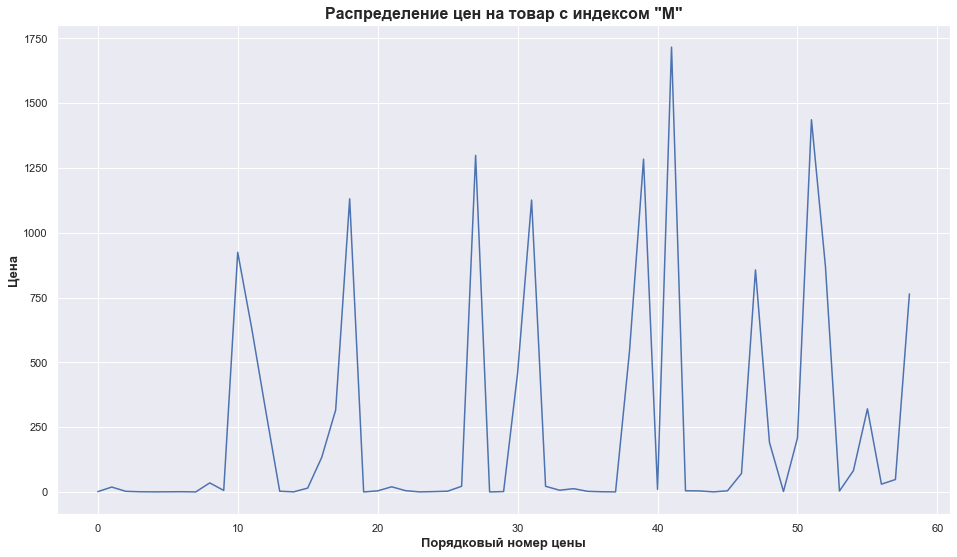

In [19]:
M_costs_plot = product_codes.query('product_id == "M"').reset_index(drop=True)
plt.figure(figsize=(16, 9))
plt.plot(M_costs_plot.index, M_costs_plot.cost_product)
captions_to_graphics(
    'Распределение цен на товар с индексом "М"',
    'Порядковый номер цены',
    'Цена')
plt.show()


На данном графике нет никакой закономерности. Чаще товар отдавали практически даром.

Вернёмся к вопросу о чеках и скидках. Сделаем два предположения:
- **изменение цены товара привязано к конкретному дню**. Тогда, количество вариантов цены на товар, равно **количеству дней**, в которые была фактическая продажа;
- **изменение цены товара привязано к количеству данного товара в чеке**. Тогда, количество вариантов цены на товар, равно **количество чеков** с одинаковым количеством конкретного товара. 

Для проверки создадим отдельный столбец с датой чека:

In [20]:
retail_dataset_step1['purchase_day'] = retail_dataset_step1.purchase_dt.astype('datetime64[D]')
retail_dataset_step1.head(3)

,purchase_id,product_id,count_products,purchase_dt,customer_id,shop_id,loyal,purchase_day
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,0,2016-12-10
1,538862,22195,0,2016-12-14 14:11:00,22389.0,0,1,2016-12-14
2,538855,21239,7,2016-12-14 13:50:00,22182.0,0,1,2016-12-14


Сгруппируем данные по дням, и найдём:
- количество дней, в которые была фактическая продажа;
- количество чеков с одинаковым количеством конкретного товара.

In [21]:
cost_product_days = retail_dataset_step1\
    .query('product_id == "DOT"')\
    .groupby('product_id', as_index=False)\
    .agg({'purchase_day': 'count'})
    
display(cost_product_days)
DOT_costs_plot.shape[0]

,product_id,purchase_day
0,DOT,175


174

Близко. Проверим на соседнем товаре:

In [22]:
cost_product_days = retail_dataset_step1\
    .query('product_id == "M"')\
    .groupby('product_id', as_index=False)\
    .agg({'purchase_day': 'count'})
    
display(cost_product_days)
M_costs_plot.shape[0]

,product_id,purchase_day
0,M,85


59

Полученные результаты не противоречат предположению о смене цены по дням (дней больше, чем вариантов цен), но и не доказывают.

Проверим по "размеру" чека:

In [23]:
cost_product_purchase_DOT = retail_dataset\
    .query('product_id == "DOT"')\
    .groupby('count_products', as_index=False)\
    .agg({'purchase_id': 'count'})
cost_product_purchase_DOT

,count_products,purchase_id
0,-2,1
1,0,174


Близко. Проверим на соседнем товаре:

In [24]:
cost_product_purchase_M = retail_dataset\
    .query('product_id == "M"')\
    .groupby('count_products', as_index=False)\
    .agg({'purchase_id': 'count'})
cost_product_purchase_M

,count_products,purchase_id
0,-201,1
1,-37,1
2,-9,1
3,-5,1
4,-3,2
5,-2,23
6,0,35
7,1,7
8,3,3
9,4,1


**Привязку вариантов цены ко времени/событию найти не удалось.**  

Выше мы обнаружили "бесплатные" товары. Проверим количество нулевых цен:

In [25]:
product_null_cost = product_codes.query('cost_product == 0').shape[0]
product_null_cost

382

Предположим, что эти товары отдавались по скидке или акции. Оставляем нулевые значения. Создадим новую таблицу с ценами. На каждый товар рассчитаем среднее арифметическое. Так мы избавимся от дубликатов:

In [26]:
product_costs = product_codes\
    .groupby('product_id', as_index=False)\
    .agg({'cost_product': 'mean'})
product_costs

,product_id,cost_product
0,10002,1.380
1,10080,0.850
2,10120,0.210
3,10123C,0.650
4,10124A,0.420
...,...,...
3154,gift_0001_20,16.845
3155,gift_0001_30,25.265
3156,gift_0001_40,34.040
3157,gift_0001_50,42.550


<a id=1_5></a>
### 1.5.Обработка пропусков
[вверх](#up)

Проверим данные на пропуски. Выше мы обнаружили нулевые значения цен, и нулевые значения по количеству товара. Объяснить нулевое количество - достаточно проблематично. Посмотрим, сколько таких значений:

In [27]:
retail_dataset_step1.query('count_products == 0').shape[0]

32362

Удалим их:

In [28]:
retail_dataset_step2 = retail_dataset_step1.query('count_products != 0').copy()
retail_dataset_len_step2 = retail_dataset_step2.shape[0]
print('Удалили данных на данном этапе: {:.1%}. Всего: {:.1%}'.format(
    1 - retail_dataset_len_step2/retail_dataset_len_step1,
    1 - retail_dataset_len_step2/retail_dataset_len_original))

Удалили данных на данном этапе: 31.0%. Всего: 31.7%


Проанализируем пропуски id покупателей.

Из условия видим, что доступ в магазин осуществляется по карте. С покупателем могут зайти и другие люди, не имеющие карточку сети, но имеющие отношение к покупателю (коллеги, друзья, родственники).  
При этом, действует программа лояльности, предоставляющая скидки и бонусы. Покупатель заплатил ежемесячную плату, а значит рассчитывает на выгоду.  
Логично предположить, что при оплате, НЕ воспользуется карточкой только тот, кто не участвует в программе.

Технически, определить лояльность без карточки невозможно. Проверим:

In [29]:
retail_dataset_step2.query('customer_id == "NaN"').loyal.value_counts()

0    16268
Name: loyal, dtype: int64

Возможно, значение "0" присвается всем покупкам, совершённым без предъявления карты лояльности.  
В каких магазинах чаще всего отсутствуют данные:

In [30]:
retail_dataset_step2.query('customer_id == "NaN"').shop_id.value_counts()

0     16075
6       124
25       53
21       14
23        2
Name: shop_id, dtype: int64

**За три контрольных месяца, покупки без карточек совершались только в 5 магазинах. В этом есть какая-то закономерность - нужно смотреть на месте.**

1. Допустим, клиент делает только одну покупку (один чек) в день. Мы могли бы сгруппировать "неопределённые" покупки по id чеков, и присвоить каждому некий уникальный id покупателя. В таком случае, мы "поделим" одного человека на два и более, не зная о реальном количестве пересечений по чекам.

2. Допустим, все "неопределённые" покупки совершали клиенты, id которых фигурирует в других чеках. Тогда, удалив пропуски, мы теряем неопределённу часть данных о пользователях, не входящих в программу лояльности. Условно, вместо 30 покупок за три месяца, клиент совершил только 10 (остальные мы удалили).

В первом и втором варианте, "вес" нелояльного покупателя уменьшается. Но, первый вариант не исключает покупку человеком, вообще не имеющим карточки торговой сети. Т.е., эти покупки могут иметь третий признак: "2" - не является клиентом. Удаляем пропуски:

In [31]:
retail_dataset_step3 = retail_dataset_step2.query('customer_id != "NaN"').copy()
retail_dataset_len_step3 = retail_dataset_step3.shape[0]
print('Удалили данных на данном этапе: {:.1%}. Всего: {:.1%}'.format(
    1 - retail_dataset_len_step3/retail_dataset_len_step2,
    1 - retail_dataset_len_step3/retail_dataset_len_original))

Удалили данных на данном этапе: 22.6%. Всего: 47.1%


**Данные предобработаны, можно приступать к исследовательскому анализу.**

## 2.Исследовательский анализ данных

<a id=2_1></a>
### 2.1.Поиск аномалий.
[вверх](#up)

Выше мы обнаружили большое количество "неопределённых" покупок в магазине "0". Проверим количество покупок по всем магазинам:

In [32]:
retail_dataset_step3.shop_id.value_counts()

0     48253
4      1692
1      1462
6       873
8       510
3       483
7       311
10      292
12      270
2       252
18      215
5       178
11      167
14      117
19       73
9        61
15       60
16       57
26       56
27       45
17       40
22       38
13       35
24       32
28       30
20       28
21       18
30       15
29        9
Name: shop_id, dtype: int64

Подавляющее количество покупок приходяться на один магазин. Предположим, что это оптовая база. Меньше всего, на магазин №29. 

Девять покупок за три месяца? Проверим:

In [33]:
retail_dataset_29 = retail_dataset_step3.query('shop_id == 29').copy()
retail_dataset_29.purchase_dt.describe()

count                       9
unique                      1
top       2017-02-24 10:34:00
freq                        9
first     2017-02-24 10:34:00
last      2017-02-24 10:34:00
Name: purchase_dt, dtype: object

Один праздничный день. Все покупки совершены в течении минуты. Проверим, идут ли они по одному чеку:

In [34]:
retail_dataset_29.purchase_id.value_counts()

544838    9
Name: purchase_id, dtype: int64

Один единственный клиент за весь день. Проверим количество чеков на каждый магазин, и количество уникальных дней продаж (по исходному датасету):

In [35]:
purchases_shop = retail_dataset_step3\
    .groupby('shop_id')\
    .agg({'purchase_id': 'nunique', 'purchase_day': ['nunique', 'min', 'max']})\
    .sort_values(by=('purchase_id', 'nunique'), ascending=False)\
    .reset_index(drop=True)
    
purchases_shop.columns = ['purchases_count', 'days_count', 'day_first', 'day_last']
purchases_shop['interval_days'] = (purchases_shop['day_last'] - purchases_shop['day_first']).dt.days + 1
purchases_shop['percent_days'] = round(purchases_shop['days_count'] / purchases_shop['interval_days'] * 100).astype('int')
purchases_shop

,purchases_count,days_count,day_first,day_last,interval_days,percent_days
0,3684,68,2016-12-01,2017-02-28,90,76
1,113,49,2016-12-01,2017-02-25,87,56
2,89,47,2016-12-01,2017-02-28,90,52
3,38,30,2016-12-01,2017-02-25,87,34
4,21,19,2016-12-03,2017-02-28,88,22
5,20,18,2016-12-03,2017-02-18,78,23
6,19,15,2016-12-01,2017-02-27,89,17
7,15,13,2016-12-01,2017-02-22,84,15
8,15,13,2016-12-03,2017-02-28,88,15
9,11,9,2016-12-03,2017-02-28,88,10


Построим график. По оси Х перечислим номера магазинов. По оси Y - процентное соотношение дней с продажами, к общему интервалу. Размер точки укажем пропорционально количеству чеков.

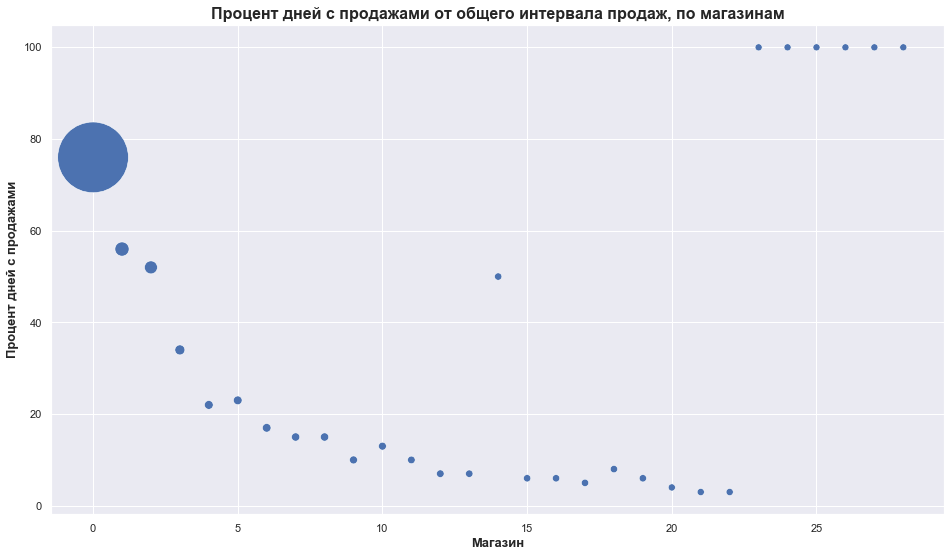

In [36]:
plt.figure(figsize=(16, 9))
sns.scatterplot(
    x=purchases_shop.index,
    y=purchases_shop.percent_days,
    size=purchases_shop.purchases_count,
    sizes=(50,5000),
    legend=False)
captions_to_graphics(
    'Процент дней с продажами от общего интервала продаж, по магазинам',
    'Магазин',
    'Процент дней с продажами')
plt.show()


Сложно рпедставить магазин, в котором покупают товар не каждый день, а только каждый пятый, и реже. Вероятнее всего, речь идёт о интернет-магазинах, или пунктах выдачи.

Так же, сложно представить магазин, отработавший один единственный день, с одним покупателем. Вероятно, речь идёт о доставке товара на адрес покупателя.

В любом случае, нас интересует, не где приобретался товар, а его количество, и общая сумма покупки. **Оставляем данные по всем магазинам.**

Выше мы находили отрицательное количество товара по чеку. И огромные максимальное и минимальное значения. Уберём их, и проверим общее распределение на графике:

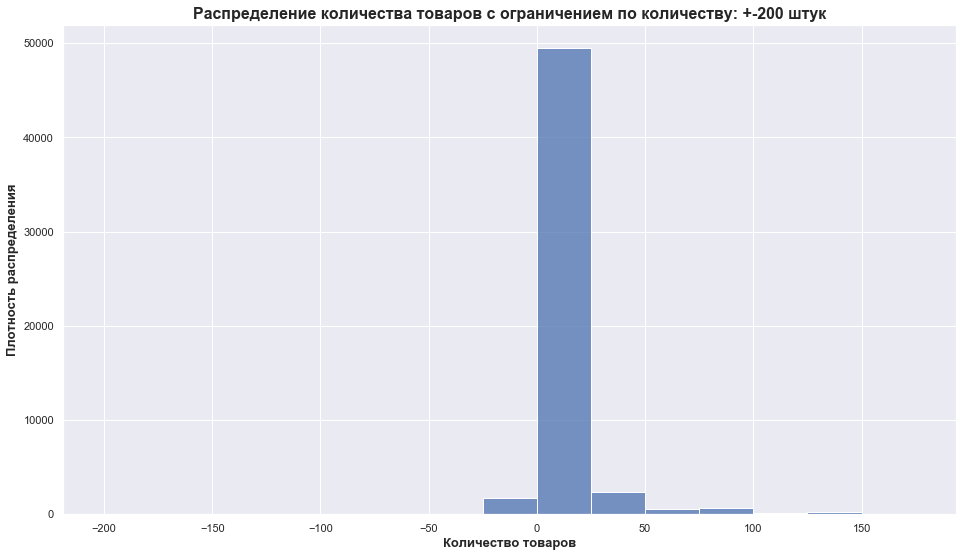

In [37]:
bord_counts = 200
count_products = retail_dataset_step3.query('-@bord_counts < count_products < @bord_counts').reset_index(drop=True)
plt.figure(figsize=(16, 9))
sns.histplot(    
    count_products.count_products,
    kde=False,
    bins=(np.arange(-bord_counts, bord_counts, bord_counts/8))    
)
captions_to_graphics(
    'Распределение количества товаров с ограничением по количеству: +-{:.0f} штук'.format(bord_counts),
    'Количество товаров',
    'Плотность распределения')
plt.show()

Выберем границу с помощью перцентилей:

In [38]:
percentiles_of_count = [0.005, 0.995]
percentiles_describe = retail_dataset_step3.count_products.describe(percentiles=percentiles_of_count).reset_index()
percentile_min = percentiles_describe.loc[4, 'count_products']
percentile_max = percentiles_describe.loc[6, 'count_products']
percentiles_describe

,index,count_products
0,count,55672.000000
1,mean,13.613037
2,std,449.843659
3,min,-74216.000000
4,0.5%,-13.000000
5,50%,5.000000
6,99.5%,199.000000
7,max,74214.000000


Удаляем 1% выбросов по количеству товара. Допускаем, что часть выбросов могли входить в состав чека вместе с другими товарами. Проверять входимость и удалять чеки целиком не станем:

In [39]:
retail_dataset_step4 = retail_dataset_step3.query('@percentile_min < count_products < @percentile_max').copy()
retail_dataset_len_step4 = retail_dataset_step4.shape[0]
print('Удалили данных на данном этапе: {:.1%}. Всего: {:.1%}'.format(
    1 - retail_dataset_len_step4/retail_dataset_len_step3,
    1 - retail_dataset_len_step4/retail_dataset_len_original))

Удалили данных на данном этапе: 1.1%. Всего: 47.7%


Проверим, есть ли пересечения отрицательного количества товара и положительного в одном чеке. Создадим серию списков с количеством товаров в чеке:

In [40]:
count_products_cross = retail_dataset_step4[['purchase_id', 'customer_id', 'loyal', 'count_products']].copy()
count_products_cross = count_products_cross\
    .groupby(['purchase_id', 'customer_id', 'loyal'], as_index=False)\
    .agg({'count_products': lambda x: list(x)})
count_products_cross

,purchase_id,customer_id,loyal,count_products
0,536365,23529.0,1,"[5, 5, 5, 5, 7, 5, 1]"
1,536366,23529.0,1,"[5, 5]"
2,536367,18726.0,0,"[5, 5, 2, 3, 7, 1, 5, 31, 3, 2, 5, 2]"
3,536368,18726.0,0,"[2, 2, 5, 2]"
4,536369,18726.0,0,[2]
...,...,...,...,...
3942,C544902,18041.0,0,"[-2, -2]"
3943,C545003,23910.0,1,[-2]
3944,C545040,19363.0,0,[-2]
3945,C545068,19836.0,0,[-12]


С помощью функции добавим столбец с результатом проверки на пересечение:

In [41]:
def purchase_has_cross(row):
    """
    Принимает на вход столбец с данными типа list.
    Если длина листа равна 1 - возвращает "0".
    Перебирает значения листа:
    -если попадается хоть одно отрицательное значение,
    в переменную minus передаёт единицу;
    -если попадается хоть одно положительное значение,
    в переменную plus передаёт единицу.
    Если переменные равны, возвращает "1", если нет - "0"
    0 - нет пересечений положительных и отрицательных значений;
    1 - есть.
    """    
    if len(row) == 1:
        return 0
    minus = 0
    plus = 0
    for i in row:
        if i < 0 and minus == 0:
            minus = 1
        if i > 0 and plus == 0:
            plus = 1
    if minus == plus:
        return 1
    else:
        return 0
    
count_products_cross['cross'] = count_products_cross['count_products'].apply(purchase_has_cross)
count_products_cross.cross.value_counts()

0    3947
Name: cross, dtype: int64

Пересечений нет.

## 3.Анализ программы лояльности

<a id=3_1></a>
### 3.1.Частота покупок на одного клиента: в неделю, в месяц, в день
[вверх](#up)

Рассчитаем частоту покупок на одного клиента в неделю и месяц. Для этого, создадим дополнительные столбцы:

In [42]:
retail_clean = retail_dataset_step4.copy()
retail_clean['year']  = retail_clean['purchase_day'].dt.year
retail_clean['month'] = retail_clean['purchase_day'].dt.month
retail_clean['week']  = retail_clean['purchase_day'].dt.week
retail_clean['day']   = retail_clean['purchase_day'].dt.day

retail_clean.head(2)

,purchase_id,product_id,count_products,purchase_dt,customer_id,shop_id,loyal,purchase_day,year,month,week,day
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,0,2016-12-10,2016,12,49,10
2,538855,21239,7,2016-12-14 13:50:00,22182.0,0,1,2016-12-14,2016,12,50,14


Рассчитаем метрики:

In [43]:
dau_visits = int(
    retail_clean\
    .groupby(['year', 'month', 'week', 'day'])\
    .agg({'customer_id': 'nunique'}).mean())
wau_visits = int(
    retail_clean\
    .groupby(['year', 'month', 'week'])\
    .agg({'customer_id': 'nunique'}).mean())
mau_visits = int(
    retail_clean\
    .groupby(['year', 'month'])\
    .agg({'customer_id': 'nunique'}).mean())

print('\033[1m' + 'Количество уникальных покупателей:')
print('- в день   (DAU) -', dau_visits)
print('- в неделю (WAU) -', wau_visits)
print('- в месяц  (MAU) -', mau_visits)

Количество уникальных покупателей:
- в день   (DAU) - 51
- в неделю (WAU) - 229
- в месяц  (MAU) - 824


<a id=3_2></a>
### 3.2.Среднее количество товаров  в корзине
[вверх](#up)

Рассчитаем среднее количество товара в корзине. Воспользуемся таблицей с количеством товаров:

In [44]:
count_products_cross.head(3)

,purchase_id,customer_id,loyal,count_products,cross
0,536365,23529.0,1,"[5, 5, 5, 5, 7, 5, 1]",0
1,536366,23529.0,1,"[5, 5]",0
2,536367,18726.0,0,"[5, 5, 2, 3, 7, 1, 5, 31, 3, 2, 5, 2]",0


Добавим столбцы с количеством всех продуктов в корзине, количеством видов товаров, и средним количеством по всем товарам внутри корзины:

In [45]:
count_products_mean = count_products_cross.copy()
count_products_mean['sum_products'] = count_products_mean['count_products'].map(lambda x: sum(x))
count_products_mean['types_count'] = count_products_mean['count_products'].map(lambda x: len(x))
count_products_mean['mean_count'] = count_products_mean['sum_products'] / count_products_mean['types_count']
count_products_mean['mean_count'] = round(count_products_mean['mean_count'], 1)
count_products_mean.head()

,purchase_id,customer_id,loyal,count_products,cross,sum_products,types_count,mean_count
0,536365,23529.0,1,"[5, 5, 5, 5, 7, 5, 1]",0,33,7,4.7
1,536366,23529.0,1,"[5, 5]",0,10,2,5.0
2,536367,18726.0,0,"[5, 5, 2, 3, 7, 1, 5, 31, 3, 2, 5, 2]",0,71,12,5.9
3,536368,18726.0,0,"[2, 2, 5, 2]",0,11,4,2.8
4,536369,18726.0,0,[2],0,2,1,2.0


Построим график распределения среднего количества товаров в корзине разных типов. Возврат учитывать не будем:

In [46]:
def make_graphics(data, column_x):
    plt.figure(figsize=(16, 4))
    sns.boxplot(
        y='loyal',
        x=column_x,
        data=data,
        orient='h')

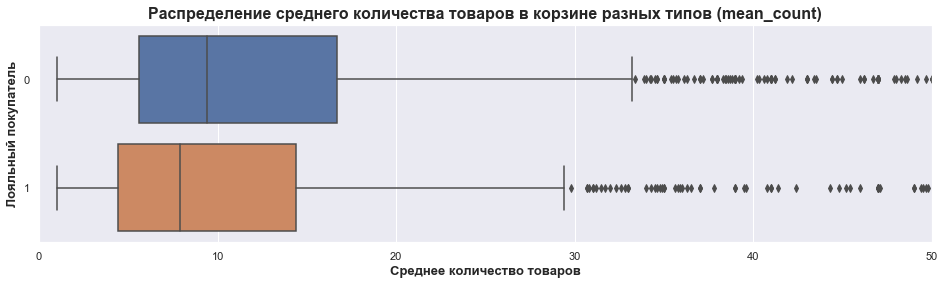

In [47]:
make_graphics(
    data=count_products_mean.query('mean_count > 0'),
    column_x='mean_count')
captions_to_graphics(
    'Распределение среднего количества товаров в корзине разных типов (mean_count)',
    'Среднее количество товаров',
    'Лояльный покупатель')
plt.xlim((0, 50))

plt.show()

Построим график распределения количества типов товаров в корзине:

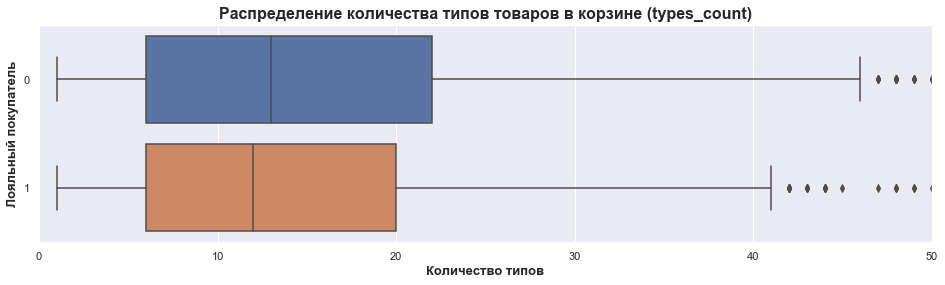

In [48]:
make_graphics(
    data=count_products_mean.query('mean_count > 0'),
    column_x='types_count')
captions_to_graphics(
    'Распределение количества типов товаров в корзине (types_count)',
    'Количество типов',
    'Лояльный покупатель')
plt.xlim((0, 50))

plt.show()

Построим график распределения общего количества всех видов товаров:

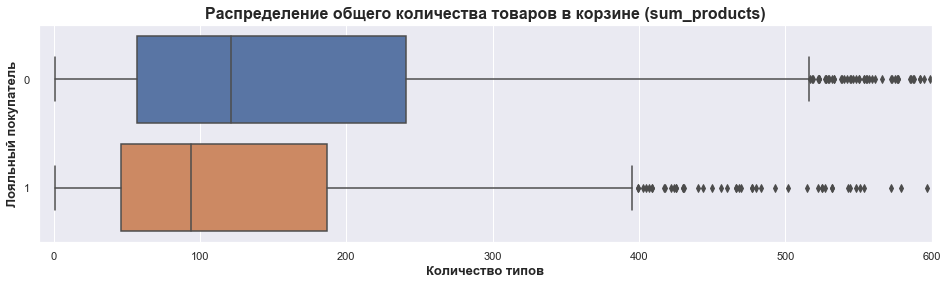

In [49]:
make_graphics(
    data=count_products_mean.query('mean_count > 0'),
    column_x='sum_products')
captions_to_graphics(
    'Распределение общего количества товаров в корзине (sum_products)',
    'Количество типов',
    'Лояльный покупатель')
plt.xlim((-10, 600))

plt.show()

Выведем точные значения:

In [50]:
purchase_mean_products_loyal = count_products_mean\
    .query('sum_products > 0 and loyal == 1').sum_products.mean()
purchase_mean_products_no_loyal = count_products_mean\
    .query('sum_products > 0 and loyal == 0').sum_products.mean()
print('Среднее количество товаров в корзине:\n\
-лояльных клиентов: {:.1f}\n-не лояльных клиентов: {:.1f}'\
      .format(purchase_mean_products_loyal,
              purchase_mean_products_no_loyal))

Среднее количество товаров в корзине:
-лояльных клиентов: 157.1
-не лояльных клиентов: 212.0


**Корзины покупателей входящих в программу лояльности отстают по всем параметрам.**

<a id=3_3></a>
### 3.3.Средняя сумма корзины
[вверх](#up)

Рассчитаем сумму каждой корзины (чека). Присоединим к таблице покупок данные о цене товара, и рассчитаем общую чтоимость внутри чека:

In [51]:
retail_clean_whis_cost = pd.merge(
    retail_clean, product_costs, how='left', on='product_id')
retail_clean_whis_cost['total_cost_products'] = retail_clean_whis_cost['count_products'] * retail_clean_whis_cost['cost_product']
retail_clean_whis_cost.head()

,purchase_id,product_id,count_products,purchase_dt,customer_id,shop_id,loyal,purchase_day,year,month,week,day,cost_product,total_cost_products
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,0,2016-12-10,2016,12,49,10,1.810000,19.910
1,538855,21239,7,2016-12-14 13:50:00,22182.0,0,1,2016-12-14,2016,12,50,14,1.474000,10.318
2,537795,82494L,5,2016-12-08 13:03:00,22892.0,0,1,2016-12-08,2016,12,49,8,5.145000,25.725
3,543647,21987,3,2017-02-10 19:49:00,18520.0,0,0,2017-02-10,2017,2,6,10,0.936667,2.810
4,538533,22294,9,2016-12-13 10:31:00,20475.0,0,0,2016-12-13,2016,12,50,13,1.820000,16.380


Сгруппируем данные по чекам:

In [52]:
purchase_volume = retail_clean_whis_cost\
    .groupby(['purchase_id', 'customer_id', 'loyal'], as_index=False)\
    .agg({'total_cost_products': 'sum'})
purchase_volume.head()

,purchase_id,customer_id,loyal,total_cost_products
0,536365,23529.0,1,184.471417
1,536366,23529.0,1,20.400000
2,536367,18726.0,0,295.588750
3,536368,18726.0,0,84.470000
4,536369,18726.0,0,16.600000


Построим распределение стоимости (размера) корзин по группам. Возврат учитывать не будем:

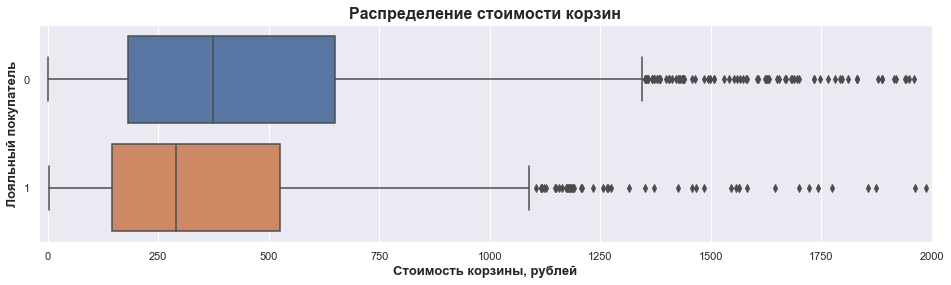

In [53]:
make_graphics(
    data=purchase_volume.query('total_cost_products > 0'),
    column_x='total_cost_products')
captions_to_graphics(
    'Распределение стоимости корзин',
    'Стоимость корзины, рублей',
    'Лояльный покупатель')
plt.xlim((-20, 2000))

plt.show()

Выведем точные значения:

In [54]:
purchase_mean_loyal = purchase_volume\
    .query('total_cost_products > 0 and loyal == 1').total_cost_products.mean()
purchase_mean_no_loyal = purchase_volume\
    .query('total_cost_products > 0 and loyal == 0').total_cost_products.mean()
print('Средняя сумма корзины:\n\
-лояльных клиентов: {:.1f}\n-не лояльных клиентов: {:.1f}'\
      .format(purchase_mean_loyal,
              purchase_mean_no_loyal))

Средняя сумма корзины:
-лояльных клиентов: 474.4
-не лояльных клиентов: 619.9


**Средняя сумма корзины покупателей входящих в программу лояльности ниже.**

<a id=3_4></a>
### 3.4.Коэффицинт удержания клиентов первого месяца RetantionRate
[вверх](#up)

В данных присутствуют логи только за три месяца. Субъективно, декабрь и январь должны резко различаться из-за сезонности. Поэтому, сравниваем только декабрьских. Выделим их в отдельную таблицу, и добавим столбец со временем жизни:

In [55]:
customer_id_m12 = retail_clean_whis_cost.query('month == 12')[['customer_id', 'purchase_day']]
customer_id_m12['cohort_month'] = customer_id_m12['purchase_day'].astype('datetime64[M]')
customer_id_m12 = customer_id_m12.drop('purchase_day', axis=1)
customer_id_m12 = customer_id_m12.drop_duplicates()
display(customer_id_m12.head(10))
print(customer_id_m12.shape[0])

,customer_id,cohort_month
0,18427.0,2016-12-01
1,22182.0,2016-12-01
2,22892.0,2016-12-01
4,20475.0,2016-12-01
16,22741.0,2016-12-01
18,19764.0,2016-12-01
20,21644.0,2016-12-01
22,23520.0,2016-12-01
23,21487.0,2016-12-01
24,21840.0,2016-12-01


926


Сгруппируем таблицу покупок:

In [56]:
retail_clean_gb = retail_clean_whis_cost\
    .groupby(['purchase_id', 'customer_id', 'loyal', 'purchase_day'], as_index=False)\
    .agg({'total_cost_products': 'sum'})[[
        'customer_id', 'loyal', 'purchase_day', 'total_cost_products']]
display(retail_clean_gb.shape[0])
display(retail_clean_gb.customer_id.nunique())
display(retail_clean_gb.head())

3947

1714

,customer_id,loyal,purchase_day,total_cost_products
0,23529.0,1,2016-12-01,184.471417
1,23529.0,1,2016-12-01,20.400000
2,18726.0,0,2016-12-01,295.588750
3,18726.0,0,2016-12-01,84.470000
4,18726.0,0,2016-12-01,16.600000


Присоединим данные по месяцу когорт:

In [57]:
customer_rr = pd.merge(
    retail_clean_gb,
    customer_id_m12,    
    how='inner',
    on='customer_id')
customer_rr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2819 entries, 0 to 2818
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          2819 non-null   float64       
 1   loyal                2819 non-null   int64         
 2   purchase_day         2819 non-null   datetime64[ns]
 3   total_cost_products  2819 non-null   float64       
 4   cohort_month         2819 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 132.1 KB


Оставим только записи для когорты декабря. Добавим столбец с активным месяцем, и столбец с временем жизни:

In [58]:
customer_rr['activity_month'] = customer_rr['purchase_day'].astype('datetime64[M]')
customer_rr['lifetime'] = customer_rr['activity_month'] - customer_rr['cohort_month']
customer_rr['lifetime'] = customer_rr['lifetime'] / np.timedelta64(1, 'M')
customer_rr['lifetime'] = customer_rr['lifetime'].round().astype('int')
customer_rr.head()

,customer_id,loyal,purchase_day,total_cost_products,cohort_month,activity_month,lifetime
0,23529.0,1,2016-12-01,184.471417,2016-12-01,2016-12-01,0
1,23529.0,1,2016-12-01,20.400000,2016-12-01,2016-12-01,0
2,23529.0,1,2016-12-01,20.400000,2016-12-01,2016-12-01,0
3,23529.0,1,2016-12-01,384.528845,2016-12-01,2016-12-01,0
4,23529.0,1,2016-12-01,384.528845,2016-12-01,2016-12-01,0


Сгруппируем все покупки по программе, месяцу когорты, и времени жизни. В качестве данных возьмём количество уникальных покупателей.

In [59]:
customer_retantion_rate = customer_rr\
    .groupby(['loyal', 'cohort_month', 'lifetime'])\
    .agg({'customer_id': 'nunique', 'total_cost_products': 'sum'}).reset_index()
customer_retantion_rate = customer_retantion_rate.rename(columns = {'total_cost_products': 'revenue'})
customer_retantion_rate

,loyal,cohort_month,lifetime,customer_id,revenue
0,0,2016-12-01,0,589,477619.899066
1,0,2016-12-01,1,239,269998.181836
2,0,2016-12-01,2,191,198286.535467
3,1,2016-12-01,0,337,224291.608826
4,1,2016-12-01,1,111,79523.312553
5,1,2016-12-01,2,118,79934.045978


Создадим таблицу с количество визитов пользователей в нулевой месяц жизни когорт:

In [60]:
customer_id_m12_count = customer_retantion_rate.query('lifetime == 0')[['loyal', 'customer_id']]
customer_id_m12_count = customer_id_m12_count.rename(columns={'customer_id': 'customer_count'})
customer_id_m12_count

,loyal,customer_count
0,0,589
3,1,337


Добавим эти значения к предыдущей таблице:

In [61]:
customer_retantion_rate = customer_retantion_rate.merge(
    customer_id_m12_count, how='left', on='loyal')
customer_retantion_rate

,loyal,cohort_month,lifetime,customer_id,revenue,customer_count
0,0,2016-12-01,0,589,477619.899066,589
1,0,2016-12-01,1,239,269998.181836,589
2,0,2016-12-01,2,191,198286.535467,589
3,1,2016-12-01,0,337,224291.608826,337
4,1,2016-12-01,1,111,79523.312553,337
5,1,2016-12-01,2,118,79934.045978,337


Добавим искомый столбец Retention Rate:

In [62]:
customer_retantion_rate['retention'] = customer_retantion_rate['customer_id'] / customer_retantion_rate['customer_count']
customer_retantion_rate

,loyal,cohort_month,lifetime,customer_id,revenue,customer_count,retention
0,0,2016-12-01,0,589,477619.899066,589,1.000000
1,0,2016-12-01,1,239,269998.181836,589,0.405772
2,0,2016-12-01,2,191,198286.535467,589,0.324278
3,1,2016-12-01,0,337,224291.608826,337,1.000000
4,1,2016-12-01,1,111,79523.312553,337,0.329377
5,1,2016-12-01,2,118,79934.045978,337,0.350148


Построим тепловую карту:

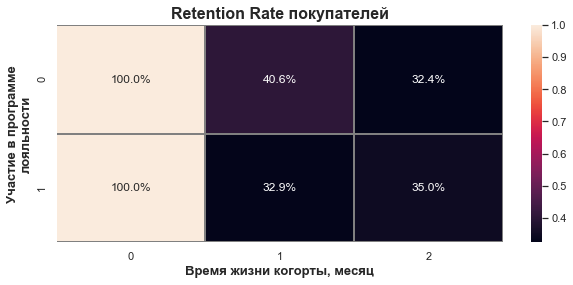

In [63]:
retention_pivot = customer_retantion_rate.pivot_table(
    index='loyal',
    columns='lifetime',
    values='retention')

plt.figure(figsize = (10, 4))
sns.heatmap(retention_pivot,
            annot = True,
            fmt = '.1%',
            linewidths = 1,
            linecolor = 'grey')
captions_to_graphics(
    'Retention Rate покупателей',
    'Время жизни когорты, месяц',
    'Участие в программе\nлояльности')

plt.show()

**Retantion Rate лояльных покупателей в первый месяц жизни ниже, а во второй месяц - становится выше. Возможно, что удержание  и на более длительный срок у лояльных клиентов будет выше. Текущих данных недостаточно**

<a id=3_5></a>
### 3.5.Ценность клиентов первого месяца LTV
[вверх](#up)

Воспользуемся таблицей из предыдущего раздела:

In [64]:
customer_retantion_rate

,loyal,cohort_month,lifetime,customer_id,revenue,customer_count,retention
0,0,2016-12-01,0,589,477619.899066,589,1.000000
1,0,2016-12-01,1,239,269998.181836,589,0.405772
2,0,2016-12-01,2,191,198286.535467,589,0.324278
3,1,2016-12-01,0,337,224291.608826,337,1.000000
4,1,2016-12-01,1,111,79523.312553,337,0.329377
5,1,2016-12-01,2,118,79934.045978,337,0.350148


Добавим столбец со средним доходом с покупателя:

In [65]:
customer_ltv = customer_retantion_rate.copy()
customer_ltv['revenue_per_user'] = customer_ltv['revenue'] / customer_ltv['customer_count']
customer_ltv

,loyal,cohort_month,lifetime,customer_id,revenue,customer_count,retention,revenue_per_user
0,0,2016-12-01,0,589,477619.899066,589,1.000000,810.899659
1,0,2016-12-01,1,239,269998.181836,589,0.405772,458.400988
2,0,2016-12-01,2,191,198286.535467,589,0.324278,336.649466
3,1,2016-12-01,0,337,224291.608826,337,1.000000,665.553735
4,1,2016-12-01,1,111,79523.312553,337,0.329377,235.974221
5,1,2016-12-01,2,118,79934.045978,337,0.350148,237.193015


Мы не располагаем маржинальностью, и считаем, что она равна 100%. Так же, добавим ежемесечную плату для когорт:

In [66]:
margin_rate = 1.0
loyal_cost_df = pd.DataFrame({'loyal': [0, 1], 'loyal_cost': [0, 200]})
customer_ltv = pd.merge(
    customer_ltv,
    loyal_cost_df,
    how='inner',
    on='loyal')
customer_ltv['ltv'] = customer_ltv['revenue_per_user'] * margin_rate + customer_ltv['loyal_cost']
customer_ltv

,loyal,cohort_month,lifetime,customer_id,revenue,customer_count,retention,revenue_per_user,loyal_cost,ltv
0,0,2016-12-01,0,589,477619.899066,589,1.000000,810.899659,0,810.899659
1,0,2016-12-01,1,239,269998.181836,589,0.405772,458.400988,0,458.400988
2,0,2016-12-01,2,191,198286.535467,589,0.324278,336.649466,0,336.649466
3,1,2016-12-01,0,337,224291.608826,337,1.000000,665.553735,200,865.553735
4,1,2016-12-01,1,111,79523.312553,337,0.329377,235.974221,200,435.974221
5,1,2016-12-01,2,118,79934.045978,337,0.350148,237.193015,200,437.193015


Сформируем сводную таблицу по когортам и месяцам жизни:

In [67]:
ltv_pivot = customer_ltv.pivot_table(
    index='loyal',
    columns='lifetime',
    values='ltv')
ltv_pivot

lifetime,0,1,2
loyal,,,
0,810.899659,458.400988,336.649466
1,865.553735,435.974221,437.193015


Для рассчёта LTV произведём накопительное суммирование, и отобразим на тепловой карте:

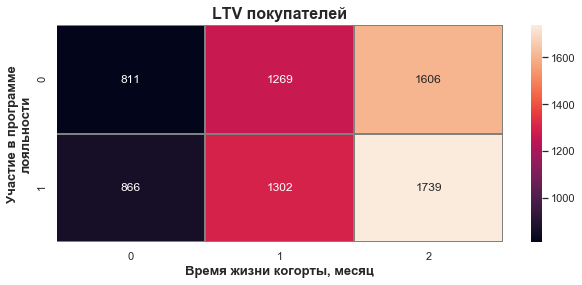

In [68]:
ltv_pivot = ltv_pivot.cumsum(axis=1).round(2)

plt.figure(figsize = (10, 4))
sns.heatmap(ltv_pivot,
            annot = True,
            fmt = '.0f',
            linewidths = 1,
            linecolor = 'grey')
captions_to_graphics(
    'LTV покупателей',
    'Время жизни когорты, месяц',
    'Участие в программе\nлояльности')

plt.show()

**С учётом ежемесячной платы, LTV покупателей программы лояльности выше.**

## 4.Проверка статистических гипотез

<a id=4_1></a>
### 4.1.Количество товаров  в корзине
[вверх](#up)

Среднее количество товаров в корзине "лояльных" клиентов не отличается от среднего размера корзины клиентов не входящих в программу лояльности. Гипотеза двусторонняя.

In [69]:
def ttest_make_and_print(sample_1, sample_2, alpha=.05):
    results = st.ttest_ind(sample_1, sample_2)
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу, между величинами есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать величины разными") 

In [70]:
ttest_make_and_print(
    count_products_mean.query('loyal == 0').sum_products,
    count_products_mean.query('loyal == 1').sum_products,
    alpha=.05)

p-значение: 0.00023591491819973724
Отвергаем нулевую гипотезу, между величинами есть значимая разница


<a id=4_2></a>
### 4.2.Сумма корзины
[вверх](#up)

Средняя сумма корзины "лояльных" клиентов не отличается от средней суммы корзины клиентов не входящих в программу лояльности. Гипотеза двусторонняя.

In [71]:
ttest_make_and_print(
    purchase_volume.query('loyal == 0').total_cost_products,
    purchase_volume.query('loyal == 1').total_cost_products,
    alpha=.05)

p-значение: 0.0034800958918757
Отвергаем нулевую гипотезу, между величинами есть значимая разница


## 5.Машинное обучение

<a id=5_1></a>
### 5.1.Классификация
[вверх](#up)

Классификация с помощью логистической регрессии может показывать потенциольно лояльных клиентов.

Для этого нам потребуются сгруппированные по пользователям данные. У нас есть таблица с количественным составом корзины.

In [72]:
count_products_mean.head()

,purchase_id,customer_id,loyal,count_products,cross,sum_products,types_count,mean_count
0,536365,23529.0,1,"[5, 5, 5, 5, 7, 5, 1]",0,33,7,4.7
1,536366,23529.0,1,"[5, 5]",0,10,2,5.0
2,536367,18726.0,0,"[5, 5, 2, 3, 7, 1, 5, 31, 3, 2, 5, 2]",0,71,12,5.9
3,536368,18726.0,0,"[2, 2, 5, 2]",0,11,4,2.8
4,536369,18726.0,0,[2],0,2,1,2.0


Сгруппируем таблицу по покупателям. Для всех характеристик корзины рассчитаем медиану:

In [73]:
customer_products = count_products_mean\
    .groupby(['customer_id', 'loyal'], as_index=False)\
    .agg({'sum_products': 'median', 'types_count': 'median', 'mean_count': 'median'})
customer_products = customer_products\
    .rename(columns={'sum_products': 'sum_products_median',
                     'types_count': 'types_count_median',
                     'mean_count': 'mean_count_median'})
customer_products

,customer_id,loyal,sum_products_median,types_count_median,mean_count_median
0,18026.0,0,287.0,30.0,9.60
1,18027.0,0,916.0,11.0,95.90
2,18029.0,0,180.0,16.0,11.20
3,18031.0,0,83.0,15.0,5.50
4,18035.0,0,1180.0,36.0,32.80
...,...,...,...,...,...
1709,23938.0,1,109.0,7.0,15.60
1710,23939.0,1,47.0,11.0,4.30
1711,23948.0,1,31.0,4.0,1.45
1712,23956.0,1,-2.0,1.0,-2.00


Обратимся к таблице с суммой чеков:

In [74]:
purchase_volume.head()

,purchase_id,customer_id,loyal,total_cost_products
0,536365,23529.0,1,184.471417
1,536366,23529.0,1,20.400000
2,536367,18726.0,0,295.588750
3,536368,18726.0,0,84.470000
4,536369,18726.0,0,16.600000


Сгруппируем по покупателям. Рассчитаем медиану стоимости чека, минимальное и максимальное значения:

In [75]:
customer_costs = retail_clean_whis_cost\
    .groupby('customer_id', as_index=False)\
    .agg({'total_cost_products': ['min', 'median', 'max']})
customer_costs.columns = ['customer_id', 'min_cost', 'median_cost', 'max_cost']
customer_costs

,customer_id,min_cost,median_cost,max_cost
0,18026.0,6.957500,21.182000,101.890000
1,18027.0,23.115000,84.495000,204.622000
2,18029.0,9.350000,26.828750,33.797500
3,18031.0,11.370000,21.890000,64.570000
4,18035.0,20.125000,96.914000,299.780000
...,...,...,...,...
1709,23938.0,17.008333,66.508333,173.496667
1710,23939.0,-28.956667,20.611250,111.037500
1711,23948.0,-34.982500,21.783333,57.998333
1712,23956.0,-28.956667,-28.956667,-28.956667


Объединяем таблицы:

In [76]:
customer_features = pd.merge(
    customer_products,
    customer_costs,
    how='inner',
    on='customer_id')

customer_features

,customer_id,loyal,sum_products_median,types_count_median,mean_count_median,min_cost,median_cost,max_cost
0,18026.0,0,287.0,30.0,9.60,6.957500,21.182000,101.890000
1,18027.0,0,916.0,11.0,95.90,23.115000,84.495000,204.622000
2,18029.0,0,180.0,16.0,11.20,9.350000,26.828750,33.797500
3,18031.0,0,83.0,15.0,5.50,11.370000,21.890000,64.570000
4,18035.0,0,1180.0,36.0,32.80,20.125000,96.914000,299.780000
...,...,...,...,...,...,...,...,...
1709,23938.0,1,109.0,7.0,15.60,17.008333,66.508333,173.496667
1710,23939.0,1,47.0,11.0,4.30,-28.956667,20.611250,111.037500
1711,23948.0,1,31.0,4.0,1.45,-34.982500,21.783333,57.998333
1712,23956.0,1,-2.0,1.0,-2.00,-28.956667,-28.956667,-28.956667


Видим, что в таблицу попали данные о покупателях, сделавших за отчётный переуд только возврат товара. Удалим эти данные:

In [77]:
customer_features_clean = customer_features.query('median_cost > 0').copy()
(customer_features.shape[0] - customer_features_clean.shape[0]) / customer_features.shape[0]

0.039089848308051345

Так же, в таблицу попали данные о покупателях, сделавших за отчётный переуд возврат товара, хотя бы раз. В следующих итерациях модели машинного обучения, можно будет добавить дополнительный признак - долю возварта товаров (или чеков). На данном этапе, просто удалим эти данные:

In [78]:
customer_features_no_return = customer_features_clean.query('min_cost > 0').copy()
(customer_features.shape[0] - customer_features_no_return.shape[0]) / customer_features.shape[0]

0.2718786464410735

В нашем распоряжении данные только за три месяца. Чтобы избежать сезонности, и уровнять время жизни клиентов, выберем только декабарьские когорты:

In [79]:
customer_id_m12_list = customer_id_m12['customer_id'].to_list()
customer_features_m12 = customer_features_no_return.query('customer_id in @customer_id_m12_list')
customer_features_m12

,customer_id,loyal,sum_products_median,types_count_median,mean_count_median,min_cost,median_cost,max_cost
0,18026.0,0,287.0,30.0,9.60,6.957500,21.182000,101.890000
1,18027.0,0,916.0,11.0,95.90,23.115000,84.495000,204.622000
9,18049.0,0,438.5,34.0,9.65,0.625000,21.550000,214.620000
12,18056.0,0,433.5,38.5,11.00,4.830000,19.005000,113.150000
14,18065.0,0,172.0,5.0,47.40,22.150000,42.550000,321.300000
...,...,...,...,...,...,...,...,...
1687,23857.0,1,126.0,17.5,7.10,14.745000,22.907143,45.476667
1696,23898.0,1,54.0,11.0,5.80,6.765000,16.785417,95.130000
1700,23908.0,1,60.0,6.0,12.00,19.005000,74.392500,173.582500
1704,23918.0,1,179.0,21.0,9.80,5.412000,17.760000,168.283333


Проверим соотношение покупателей по когортам:

In [80]:
customer_features_m12.loyal.value_counts()

0    373
1    237
Name: loyal, dtype: int64

Посмотрим матрицу корреляции и отобразим

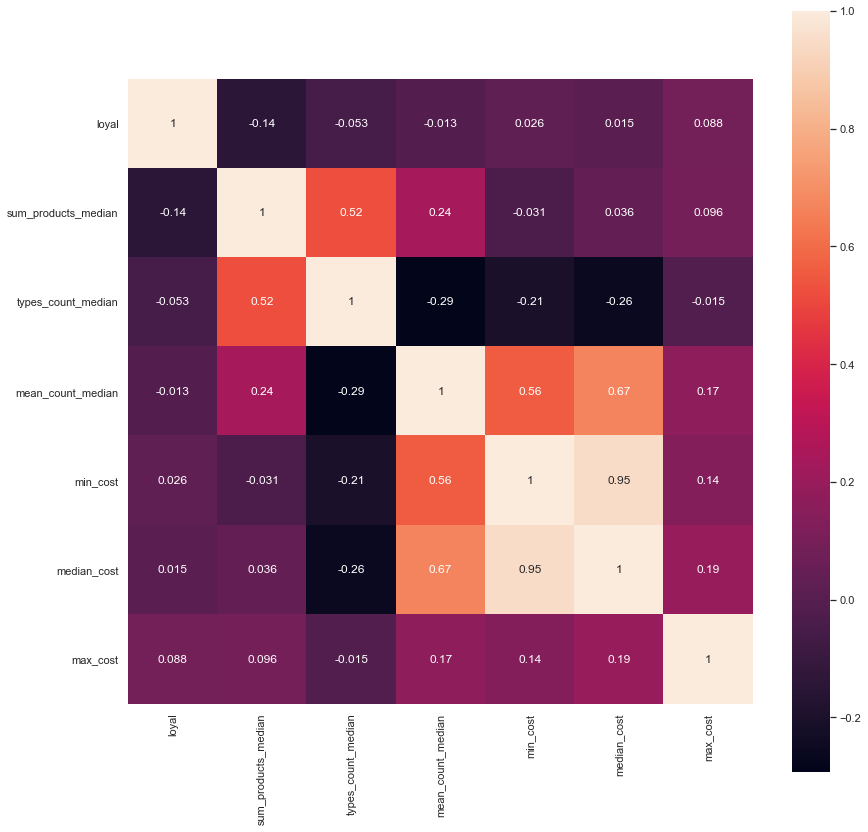

In [81]:
corr_m = customer_features_m12.drop('customer_id', axis=1).corr()

plt.figure(figsize=(14, 14))
sns.heatmap(corr_m, square = True, annot=True)
plt.show()

**Обращаем внимание на то, что корреляция между признаками и характеристикой незначительна.**  
Среди признаков, самая высокая корреляция оказалась между минимальной стоимостью корзины, и её медианой.  
Так же, получилась достаточно высокая корреляция между медианой среднего количества товаров разных типов корзины, и медианой стоимости корзины. Удалим оба признака:

In [82]:
customer_features_m12_clear = customer_features_m12.drop(['min_cost', 'mean_count_median'], axis=1).copy()

customer_features_m12_clear.head(3)

,customer_id,loyal,sum_products_median,types_count_median,median_cost,max_cost
0,18026.0,0,287.0,30.0,21.182,101.890
1,18027.0,0,916.0,11.0,84.495,204.622
9,18049.0,0,438.5,34.0,21.550,214.620


Построим модель бинарной классификации покупателей с целевой характеристикой - лояльность.

Разделим DataFrame на матрицу признаков и вектор событий:

In [83]:
X = customer_features_m12_clear.drop(['customer_id', 'loyal'], axis=1)
y = customer_features_m12_clear.loyal

Разделим данные на обучающую и валидационную выборку в соотношении 80/20:

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем признаки:

In [85]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель двумя способами: логистической регрессией, и случайным лесом. Результаты проверим метриками accuracy, precision и recall.

Создадим функцию:

In [86]:
def check_model_print_metrics(model, X_train, X_test, y_train, y_test):
    '''
    - принимает на вход тип модели и выборки (обучающая и валидационная);
    - формирует вектор событий;
    - рассчитывает метрику accuracy;
    - рассчитывает метрику precision;
    - рассчитывает метрику recall;
    - рассчитывает метрику f1_score;
    - выводит на печать название модели, и полученные метрики.
    '''
    model_ = model[0]
    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    print('\033[7m' + model[1], '\033[0m')
    print('\033[1m\033[46m',
          'Accuracy: {:.2f} | Precision: {:.2f} | Recall: {:.2f} | f1_score: {:.2f}'.format(
              accuracy_score(y_test, y_pred),
              precision_score(y_test, y_pred),
              recall_score(y_test, y_pred),
              f1_score(y_test, y_pred)),
          '\033[0m')

Создадим список моделями, и их названиями. В цикле вызомем функцию

In [87]:
model_list = [
    [LogisticRegression(solver='lbfgs'), 'Логистическая регрессия. LogisticRegression'],
    [RandomForestClassifier(n_estimators = 100), 'Cлучайный лес. RandomForestClassifier'],
    [GradientBoostingClassifier(n_estimators = 100), 'Градиентный бустинг. GradientBoostingRegressor']
]
for model in model_list:
    check_model_print_metrics(model, X_train_st, X_test_st, y_train, y_test)

Логистическая регрессия. LogisticRegression 
 Accuracy: 0.61 | Precision: 1.00 | Recall: 0.04 | f1_score: 0.08 
Cлучайный лес. RandomForestClassifier 
 Accuracy: 0.55 | Precision: 0.39 | Recall: 0.22 | f1_score: 0.29 
Градиентный бустинг. GradientBoostingRegressor 
 Accuracy: 0.58 | Precision: 0.47 | Recall: 0.35 | f1_score: 0.40 


Точность прогнозов не высокая.  
Вспомним про различия метрик precision и recall:

$$Precission=\frac{TP}{TP+FP};\ \ Recall=\frac{TP}{TP+FN}$$

- **TP** - True Positive **«истинно положительные»** Прогноз модели = 1, реальное значение = 1.
- **FP** - False Positive **«ложно положительные»** Прогноз модели = 1, реальное значение = 0.
- **FN** - False Negative **«ложно отрицательные»** Прогноз модели = 0, реальное значение = 1.

Для прогноза лояльности клиентов, лучше "диагностировать" ложный, чем пропустить истинный исход. Следовательно, модель должна выдывать минимальное количество ложно отрицательных прогнозов.

**Выбираем метрику Recall, а с ней и модель обучения "Градиентный бустинг", как наиболее оптимальный. При этом, делаем вывод, что данных для обучения модели пока не хватает.**

<a id=5_2></a>
### 5.2.Кластеризация
[вверх](#up)

Кластеризация с помощью K-Means может показать, какой процент потенциально лояльных клиентов могли попасть в программу (есть ли потенциальный рост охвата программы).

Проведём стандартизацию данных:

In [88]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

Построим матрицу расстояний, а по ней - дендрограмму:

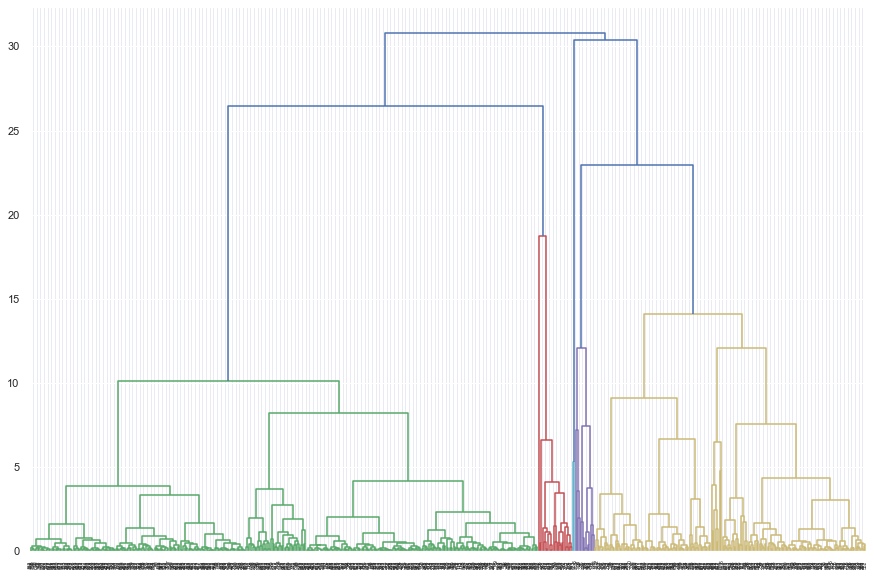

In [89]:
linked = linkage(X_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Дендограмма определила 5 кластеров. Но, 3 из них заметно отстают по количеству наблюдений (покупателей). Попробуем выделить два и три кластеров:

In [90]:
km_2 = KMeans(n_clusters = 2, random_state=0)
labels_2 = km_2.fit_predict(X_st)

km_3 = KMeans(n_clusters = 3, random_state=0)
labels_3 = km_3.fit_predict(X_st)

Проверим среднее значение для кластеров:

In [91]:
customer_features_m12_KMeans_2 = customer_features_m12_clear.copy()
customer_features_m12_KMeans_2['cluster_km'] = labels_2
display(customer_features_m12_KMeans_2.drop('customer_id', axis=1).groupby('cluster_km').mean().T)

customer_features_m12_KMeans_3 = customer_features_m12_clear.copy()
customer_features_m12_KMeans_3['cluster_km'] = labels_3
display(customer_features_m12_KMeans_3.drop('customer_id', axis=1).groupby('cluster_km').mean().T)

cluster_km,0,1
loyal,0.401559,0.319588
sum_products_median,99.468811,379.376289
types_count_median,11.088694,34.845361
median_cost,46.051824,24.440929
max_cost,162.620951,345.331542


cluster_km,0,1,2
loyal,0.403579,0.304762,1.000000
sum_products_median,98.933400,356.919048,293.500000
types_count_median,10.702783,34.514286,30.500000
median_cost,46.978467,22.260697,13.906786
max_cost,165.911813,120.564374,10404.403220


При разбиении на три кластера, получаем выброс. Если его не учитывать, можно описать закономерность таким образом. Для лояльных клиентов может быть характерно:
- **количество типов товаров в корзине и их общее количество меньше;**
- **медиана стоимости корзины выше.**

При разделении на два кластера:

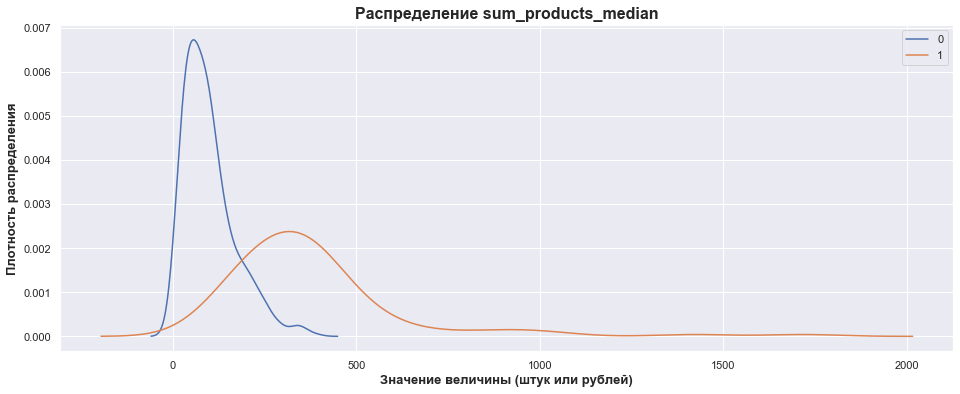

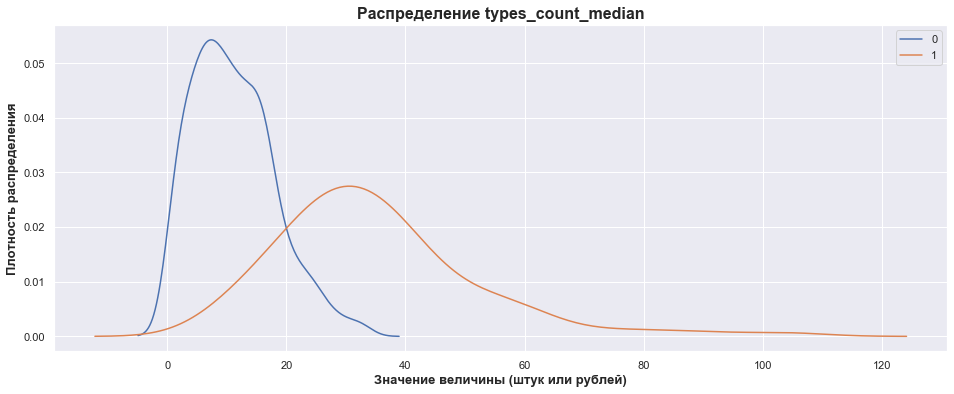

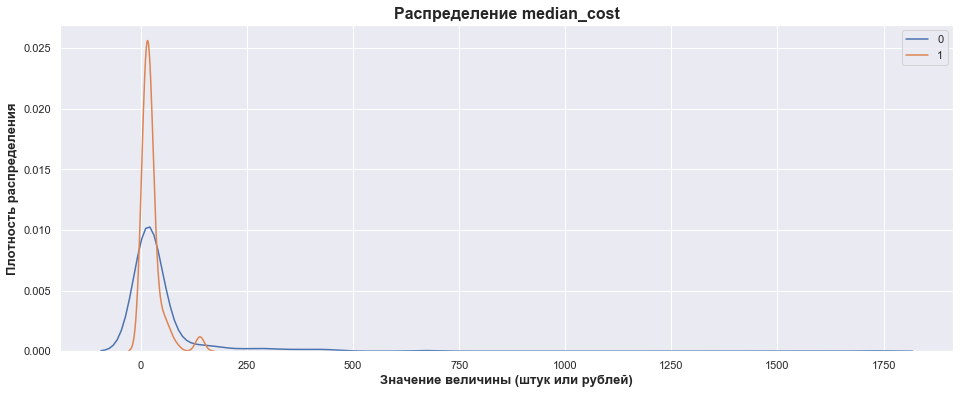

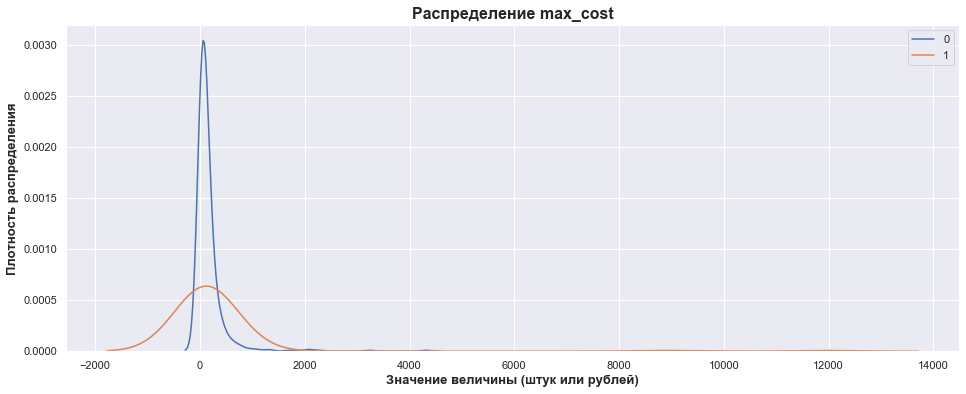

In [92]:
for column in customer_features_m12_KMeans_2.drop(['cluster_km', 'customer_id', 'loyal'], axis=1).columns:
    plt.figure(figsize=(16, 6))    
    sns.kdeplot(        
        customer_features_m12_KMeans_2.query('cluster_km == 0')[column],        
        label='0')  
    sns.kdeplot(        
        customer_features_m12_KMeans_2.query('cluster_km == 1')[column],        
        label='1')    
    plt.legend()
    captions_to_graphics(
        'Распределение ' + column,
        'Значение величины (штук или рублей)',
        'Плотность распределения')
plt.show()

Отдельно выведем график для медианы стоимости корзины, указав ограничение:

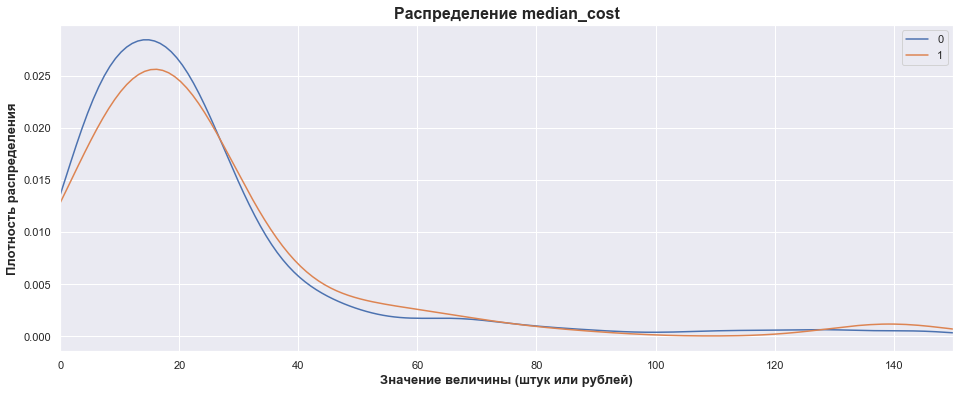

In [93]:
median_cost_lim = 150
plt.figure(figsize=(16, 6))
sns.kdeplot(customer_features_m12_KMeans_2\
    .query('cluster_km == 0 and median_cost < @median_cost_lim')['median_cost'], label='0')  
sns.kdeplot(customer_features_m12_KMeans_2\
    .query('cluster_km == 1 and median_cost < @median_cost_lim')['median_cost'], label='1')    
plt.legend()
plt.xlim(0, 150)
captions_to_graphics(
    'Распределение median_cost',
    'Значение величины (штук или рублей)',
    'Плотность распределения')
plt.show()

**Вывод по распределениям повторяет описание таблицы со средними значениями, за исключением медианы стоимости корзины. Без влияния выбросов, отличий не обнаружено.**

<a id=6_></a>
## 6.Вывод
[вверх](#up)

Выведем дополнительную информацию:

In [94]:
print('Среднее количество товаров в корзине лояльных покупателей отличается на: {:.1%}'\
      .format(1 - purchase_mean_products_loyal / purchase_mean_products_no_loyal))
print('Средняя сумма корзины лояльных покупателей отличается на: {:.1%}'\
      .format(1 - purchase_mean_loyal / purchase_mean_no_loyal))

Среднее количество товаров в корзине лояльных покупателей отличается на: 25.9%
Средняя сумма корзины лояльных покупателей отличается на: 23.5%


<b>Без привязки вариантов стоимости товаров к дате, результаты исследования могли получиться ошибочными.

Среднее количество товаров в корзине лояльных покупателей меньше на: 25.9%  
Средняя сумма корзины лояльных покупателей меньше на: 23.5%  
Оба различия статистически значимы.</b>

<b>При этом, Retantion Rate лояльных покупателей на третий месяц - становится выше.  
А с учётом ежемесячной платы, LTV покупателей программы лояльности выше.

Наилучший результат показала модель машинного обучения "Градиентный бустинг", но данных для обучения пока не хватает.  
Для лояльных клиентов может быть характерно:
- меньше, как общее количество, так и количество типов товаров в корзине</b>

### Рекомендую продолжить программу лояльности и посмотреть на динамику Retantion Rate и LTV